In [1]:
%matplotlib inline

In [2]:
import jax
import orbax
import flax
#import tensorflow as tf

import numpy as np
import jax.numpy as jnp
from jax import random

import sys
import os
sys.path.append('../')
import datasets

from flax.training import checkpoints
from models import utils as mutils
from models import ddpm
import eval_utils as eutils
import train_utils as tutils
import diffrax
from functools import partial
from tqdm import trange
from run_lib import init_model
from dynamics import get_vpsde
import matplotlib.pyplot as plt

2024-09-10 17:59:35.515648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 17:59:35.542653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 17:59:35.550788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 17:59:37.489736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from configs.sm.cifar import vpsde_less_5 as config
config = config.get_config()

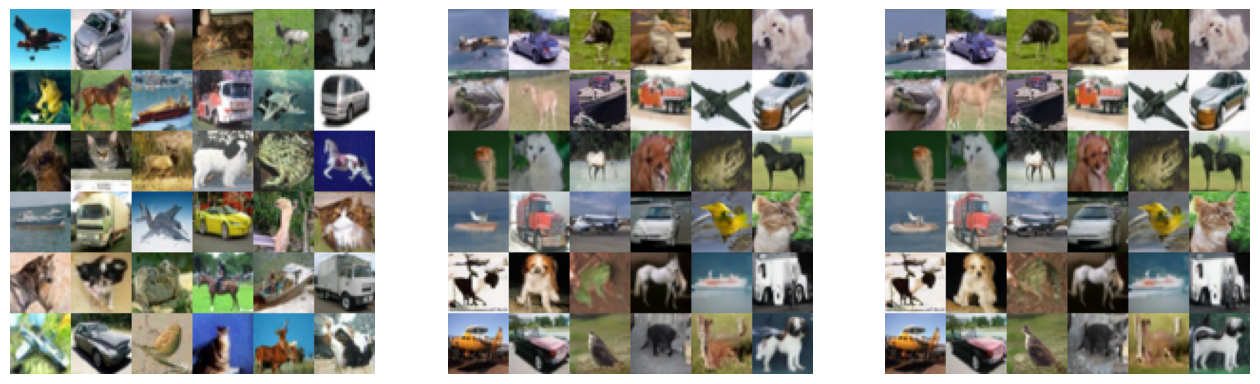

In [5]:
samples_a = '../checkpoint/cond_ab_joint_stoch_vf/eval/samples/samples_0.npz'
samples_b = '/network/scratch/k/kirill.neklyudov/5319047/eval/samples/samples_0.npz'
samples_joint = '../checkpoint/cond_ab_joint_vf/eval/samples/samples_0.npz'

def show_samples(fname):
    with open(fname, 'rb') as f:
        imgs = np.load(f)['samples']
    plt.imshow(tutils.stack_imgs(imgs/255, 6, 6), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.box(False)

plt.figure(figsize=(16,8))
plt.subplot(131)
show_samples(samples_a)
plt.subplot(132)
show_samples(samples_b)
plt.subplot(133)
show_samples(samples_joint)

In [4]:
chkpt_a = '/network/scratch/k/kirill.neklyudov/5338472/'
chkpt_b = '/network/scratch/k/kirill.neklyudov/5342288/'

In [5]:
key = random.PRNGKey(0)

chkpts = [chkpt_a, chkpt_b]

states = []
models = []
for chkpt in chkpts:
    state, _, _, model = init_model(key, config, chkpt)
    print(state.step)
    states.append(state)
    models.append(model)

2024-09-25 18:45:23.229131: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.68). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


500001


500001


In [4]:
def get_joint_vf(key, models, states):
  beta_0 = 0.1
  beta_1 = 20.0
  log_alpha = lambda t: -0.5*t*beta_0-0.25*t**2*(beta_1-beta_0)
  # log_sigma = lambda t: jnp.log(jnp.sqrt(-jnp.expm1(-t*beta_0-0.5*t**2*(beta_1-beta_0))))
  log_sigma = lambda t: jnp.log(t)
  dlog_alphadt = jax.grad(lambda t: log_alpha(t).sum())
  dlog_sigmadt = jax.grad(lambda t: log_sigma(t).sum())
  # beta_t = s_t d/dt log(s_t/alpha_t)
  # beta = lambda t: jnp.exp(log_sigma(t))*(dlog_sigmadt(t) - dlog_alphadt(t))
  beta = lambda t: (1 + 0.5*t*beta_0 + 0.5*t**2*(beta_1-beta_0))
  nets = []
  for i in range(len(models)):
    nets.append(mutils.get_model_fn(models[i], states[i].params_ema, train=False))

  def joint_vf(t, data, args):
    key, labels, dt = args['key'], args['labels'], args['dt']
    key = jax.random.fold_in(key, t*10_000)
    x, logq = data
    vfs = []
    dlogdx = []
    div = []
    for i in range(len(nets)):
      key, iter_key = jax.random.split(key)
      eps = jax.random.randint(iter_key, x.shape, 0, 2).astype(float)*2 - 1.0
      sdlogdx_fn = lambda _x: nets[i](t*jnp.ones((_x.shape[0],1,1,1)), _x, labels)
      sdlogdx, jvp_val = jax.jvp(sdlogdx_fn, (x,), (eps,))
      vfs.append(dlog_alphadt(t)*x - beta(t)*sdlogdx)
      dlogdx.append(sdlogdx/(t+1e-3))
      div.append(-beta(t)*(jvp_val*eps).sum((1,2,3)))
    vfs, dlogdx, div = jnp.stack(vfs), jnp.stack(dlogdx), jnp.stack(div)
    weights = jax.nn.softmax(logq)
    dx = -dt*(jnp.expand_dims(weights.T, (2,3,4))*vfs).sum(0)
    dlogq = -(-dt)*div + (dlogdx*(dx[None, ...] - (-dt)*vfs)).sum((2,3,4))
    dlogq = dlogq.T
    dlogq -= jnp.max(dlogq, axis=1, keepdims=True)
    return (dx, dlogq)

  return joint_vf

def get_joint_generator(models, config, vector_field):
  shape = (config.eval.batch_size//jax.local_device_count(),
           config.data.image_size, 
           config.data.image_size, 
           config.data.num_channels)

  def artifact_generator(key, labels):
    keys = jax.random.split(key, num=2)
    
    dt = 5e-3
    t = 1.0
    n = int(t/dt)
    logq = jnp.zeros((n, shape[0], len(models)))
    x = jnp.zeros((n+1,) + shape)
    x = x.at[0].set(jax.random.normal(keys[0], shape))
    for i in range(n):
      data = (x[i],logq[i])
      dx, dlogq = vector_field(t, data, args={'key': keys[1], 'labels': labels, 'dt': dt})
      x = x.at[i+1].set(x[i] + dx)
      logq = logq.at[i+1].set(logq[i] + dlogq)
      t += -dt
    return (x, logq)
    
  return artifact_generator

def get_generator(models, config, vector_field):
  shape = (config.eval.batch_size//jax.local_device_count(),
           config.data.image_size, 
           config.data.image_size, 
           config.data.num_channels)

  def artifact_generator(key, labels):
    keys = jax.random.split(key, num=2)
    
    dt = 5e-3
    t = 1.0
    n = int(t/dt)
    logq = jnp.zeros((shape[0], len(models)))
    x = jax.random.normal(keys[0], shape)
    for _ in range(n):
      data = (x,logq)
      dx, dlogq = vector_field(t, data, args={'key': keys[1], 'labels': labels, 'dt': dt})
      x += dx
      logq += dlogq
      t += -dt
    return x, n
    
  return artifact_generator

In [29]:
joint_vf = jax.jit(get_joint_vf(None, models, states))
generator = get_joint_generator(models, config, joint_vf)
generator = jax.vmap(generator, axis_name='batch')
labels = jnp.tile(jnp.arange(10), 10).reshape(jax.local_device_count(), -1)

key, *next_keys = random.split(jax.random.PRNGKey(1), num=jax.local_device_count() + 1)
next_keys = jnp.asarray(next_keys)
solution = generator(next_keys, labels)

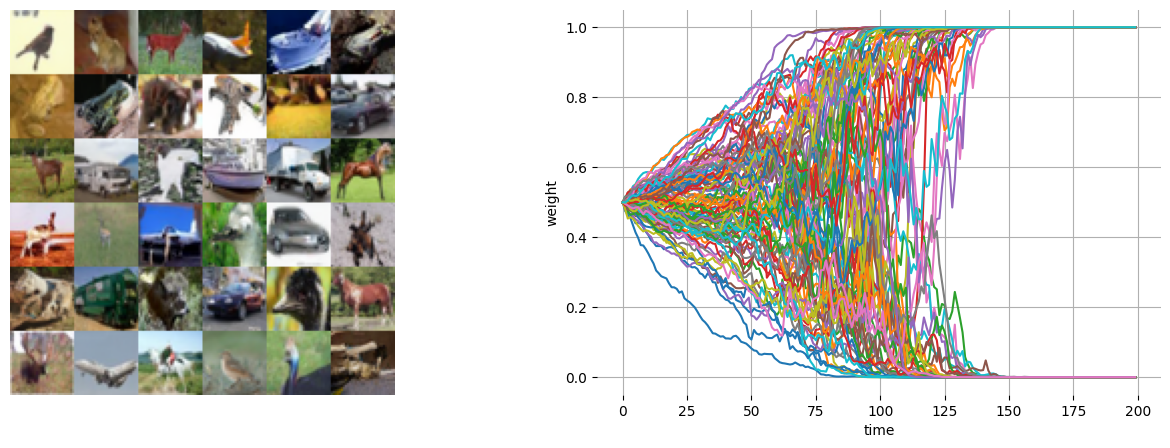

In [30]:
inverse_scaler = datasets.get_image_inverse_scaler(config)
plt.figure(figsize = (16,5))
plt.subplot(121)
plt.imshow(tutils.stack_imgs(inverse_scaler(solution[0][0,-1][:36]), 6, 6), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.subplot(122)
logq1 = solution[1][0][:,:,0]
logq2 = solution[1][0][:,:,1]
maxlq = np.maximum(logq1, logq2)
weight = np.exp(logq1 - maxlq)/(np.exp(logq2 - maxlq)+np.exp(logq1 - maxlq))
plt.plot(weight)
plt.box(False)
plt.xlabel('time')
plt.ylabel('weight')
plt.grid()

In [7]:
def get_joint_stoch_vf(key, models, states):
  beta_0 = 0.1
  beta_1 = 20.0
  log_alpha = lambda t: -0.5*t*beta_0-0.25*t**2*(beta_1-beta_0)
  # log_sigma = lambda t: jnp.log(jnp.sqrt(-jnp.expm1(-t*beta_0-0.5*t**2*(beta_1-beta_0))))
  log_sigma = lambda t: jnp.log(t)
  dlog_alphadt = jax.grad(lambda t: log_alpha(t).sum())
  dlog_sigmadt = jax.grad(lambda t: log_sigma(t).sum())
  # beta_t = s_t d/dt log(s_t/alpha_t)
  # beta = lambda t: jnp.exp(log_sigma(t))*(dlog_sigmadt(t) - dlog_alphadt(t))
  beta = lambda t: (1 + 0.5*t*beta_0 + 0.5*t**2*(beta_1-beta_0))
  nets = []
  for i in range(len(models)):
    nets.append(mutils.get_model_fn(models[i], states[i].params_ema, train=False))

  def joint_vf(t, data, args):
    key, labels, dt = args['key'], args['labels'], args['dt']
    key = jax.random.fold_in(key, t*10_000)
    x, logq = data
    sscores = []
    for i in range(len(nets)):
      sdlogdx = nets[i](t*jnp.ones((x.shape[0],1,1,1)), x, labels)
      sscores.append(sdlogdx)
    sscores = jnp.stack(sscores)
    weights = jax.nn.softmax(1e5*logq)
    balanced_sscore = (jnp.expand_dims(weights.T, (2,3,4))*sscores).sum(0)
    eps = random.normal(key, shape=x.shape)
    dx = -dt*(dlog_alphadt(t)*x - 2*beta(t)*balanced_sscore) + jnp.sqrt(2*jnp.exp(log_sigma(t))*beta(t)*dt)*eps
    # dlogq = -(dx[None,...] + dt*(dlog_alphadt(t)*x[None,...] - 2*beta(t)*sscores))**2
    # dlogq += (dx[None,...] + dt*dlog_alphadt(t)*(x+dx)[None,...])**2
    # dlogq /= 4*jnp.exp(log_sigma(t))*beta(t)*dt
    dlogq = (dlog_alphadt(t)*(x+dx)[None,...] - (dlog_alphadt(t)*x[None,...] - 2*beta(t)*sscores))
    dlogq *= (dt*(dlog_alphadt(t)*x[None,...] - 2*beta(t)*sscores) + 2*dx[None,...] + dt*dlog_alphadt(t)*(x+dx)[None,...])
    dlogq /= 4*jnp.exp(log_sigma(t))*beta(t)
    dlogq = dlogq.sum((2,3,4)).T
    # dlogq -= jnp.max(dlogq, axis=1, keepdims=True)
    return (dx, dlogq)
  return joint_vf

In [8]:
joint_vf = jax.jit(get_joint_stoch_vf(None, models, states))
generator = get_joint_generator(models, config, joint_vf)
generator = jax.vmap(generator, axis_name='batch')
labels = jnp.tile(jnp.arange(10), 10).reshape(jax.local_device_count(), -1)

key, *next_keys = random.split(jax.random.PRNGKey(1), num=jax.local_device_count() + 1)
next_keys = jnp.asarray(next_keys)
solution = generator(next_keys, labels)

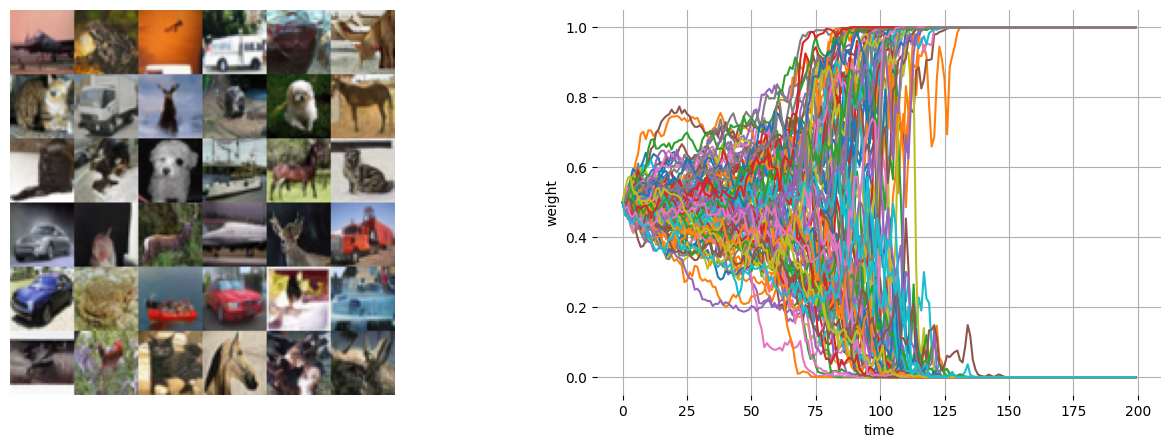

In [9]:
inverse_scaler = datasets.get_image_inverse_scaler(config)
plt.figure(figsize = (16,5))
plt.subplot(121)
plt.imshow(tutils.stack_imgs(inverse_scaler(solution[0][0,-1][:36]), 6, 6), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.subplot(122)
logq1 = solution[1][0][:,:,0]
logq2 = solution[1][0][:,:,1]
maxlq = np.maximum(logq1, logq2)
weight = np.exp(logq1 - maxlq)/(np.exp(logq2 - maxlq)+np.exp(logq1 - maxlq))
plt.plot(weight)
plt.box(False)
plt.xlabel('time')
plt.ylabel('weight')
plt.grid()

In [8]:
joint_vf = jax.jit(get_joint_vf(None, models, states))
generator = get_generator(models, config, joint_vf)
generator = jax.vmap(generator, axis_name='batch')
labels = jnp.tile(jnp.arange(10), 10).reshape(jax.local_device_count(), -1)

key, *next_keys = random.split(jax.random.PRNGKey(1), num=jax.local_device_count() + 1)
next_keys = jnp.asarray(next_keys)
solution = generator(next_keys, labels)

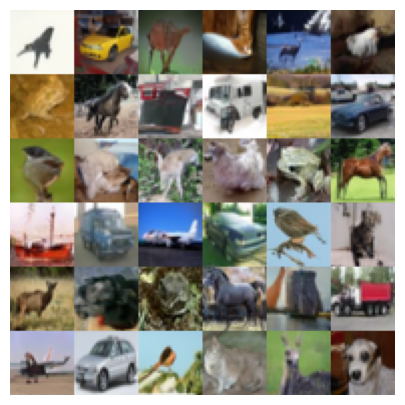

In [9]:
inverse_scaler = datasets.get_image_inverse_scaler(config)
plt.figure(figsize = (8,5))
plt.imshow(tutils.stack_imgs(inverse_scaler(solution[0][0][:36]), 6, 6), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.box(False)